# Импорты

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import warnings
warnings.filterwarnings('ignore')
import time
import joblib
import os

# Специальный импорт для HalvingGridSearchCV (экспериментальный)
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Создаем папки для сохранения
os.makedirs('saved_models', exist_ok=True)
os.makedirs('saved_searches', exist_ok=True)
os.makedirs('results', exist_ok=True)

pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

# ThresholdFrequencyEncoder

In [3]:
class ThresholdFrequencyEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, threshold=0.01, other_name='OTHER'):
        self.threshold = threshold
        self.other_name = other_name
        self.freq_maps_ = {}
        self.columns_ = []

    def fit(self, X, y=None):
        self.columns_ = X.columns.tolist()
        
        for col in self.columns_:
            value_counts = X[col].value_counts(normalize=True)
            common_categories = value_counts[value_counts >= self.threshold].index
            freq_map = {}
            
            for cat in common_categories:
                freq_map[cat] = value_counts[cat]

            other_categories = value_counts[value_counts < self.threshold].index
            other_freq = value_counts[other_categories].sum() if len(other_categories) > 0 else 0
            freq_map[self.other_name] = other_freq
            self.freq_maps_[col] = freq_map
        
        return self

    def transform(self, X):
        X_copy = X.copy()
        
        for col in self.columns_:
            if col not in X_copy.columns:
                continue
            
            temp_col = X_copy[col].astype(str)
            common_categories = list(self.freq_maps_[col].keys())
            common_categories.remove(self.other_name)
            
            temp_col = temp_col.where(
                temp_col.isin(common_categories), 
                other=self.other_name
            )
            
            encoded_values = temp_col.map(self.freq_maps_[col])
            encoded_values = encoded_values.fillna(self.freq_maps_[col][self.other_name])
            X_copy[col] = encoded_values
        
        return X_copy

    def get_feature_names_out(self, input_features=None):
        if input_features is None:
            return self.columns_
        return input_features

# Функции сохранения

In [4]:
def save_model_with_metadata(model, filename, model_name, metrics, params=None):
    """Сохраняет модель с метаданными"""
    metadata = {
        'model_name': model_name,
        'saved_at': pd.Timestamp.now(),
        'metrics': metrics,
        'params': params if params else {},
        'model_type': str(type(model).__name__)
    }
    
    joblib.dump({
        'model': model,
        'metadata': metadata
    }, filename)
    
    print(f"✓ Модель сохранена: {filename}")
    
    metadata_filename = filename.replace('.pkl', '_metadata.txt')
    with open(metadata_filename, 'w', encoding='utf-8') as f:
        f.write(f"Модель: {metadata['model_name']}\n")
        f.write(f"Дата сохранения: {metadata['saved_at']}\n")
        f.write(f"Тип модели: {metadata['model_type']}\n")
        f.write(f"\nМетрики:\n")
        for key, value in metrics.items():
            if isinstance(value, (int, float)):
                f.write(f"  {key}: {value:.4f}\n")
            else:
                f.write(f"  {key}: {value}\n")
        if params:
            f.write(f"\nПараметры:\n")
            for key, value in params.items():
                f.write(f"  {key}: {value}\n")
    
    print(f"✓ Метаданные сохранены: {metadata_filename}")

def save_scaler(scaler, filename):
    """Сохраняет scaler отдельно"""
    joblib.dump(scaler, filename)
    print(f"✓ Scaler сохранен: {filename}")

def save_preprocessor(preprocessor, filename):
    """Сохраняет препроцессор отдельно"""
    joblib.dump(preprocessor, filename)
    print(f"✓ Препроцессор сохранен: {filename}")

# Готовим данные

In [6]:
print("Загрузка данных...")
df = pd.read_csv('https://media.githubusercontent.com/media/taysumova/urfu_ml/refs/heads/main/data_sources/train.csv', index_col='id')
df_sample = df.sample(n=1500000, random_state=42)

X = df_sample.drop("Response", axis=1)
y = df_sample["Response"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    train_size=1000000,
    test_size=500000,
    stratify=y,
    random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")
print(f"Class balance in train:\n{y_train.value_counts(normalize=True)}")

# Сохраняем данные
joblib.dump({'X_train': X_train, 'X_test': X_test, 'y_train': y_train, 'y_test': y_test}, 
            'saved_models/train_test_split.pkl')
print("✓ Данные сохранены")

Загрузка данных...
Train shape: (1000000, 10)
Test shape: (500000, 10)
Class balance in train:
Response
0   0.88
1   0.12
Name: proportion, dtype: float64
✓ Данные сохранены


# Определение колонок и препроцессор

In [7]:
high_card_cols = ['Region_Code', 'Policy_Sales_Channel']
bool_cols = ['Gender', 'Vehicle_Damage']
ord_cols = ['Vehicle_Age']

preprocessor = ColumnTransformer(
    transformers=[
        ("high_cat", ThresholdFrequencyEncoder(threshold=0.01, other_name='OTHER'), high_card_cols),
        ("bool", OneHotEncoder(drop='first', sparse_output=False, dtype=np.int32), bool_cols),
        ("ord", OrdinalEncoder(
            categories=[['< 1 Year', '1-2 Year', '> 2 Years']],
            dtype=np.int32
        ), ord_cols),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

# СОХРАНЯЕМ ПРЕПРОЦЕССОР
save_preprocessor(preprocessor, 'saved_models/preprocessor.pkl')

✓ Препроцессор сохранен: saved_models/preprocessor.pkl


# Масштабирование

In [8]:
print("\n" + "="*60)
print("МАСШТАБИРОВАНИЕ ДАННЫХ")
print("="*60)

# Преобразуем данные через препроцессор
print("Преобразование данных через препроцессор...")
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Получаем имена признаков
feature_names = preprocessor.get_feature_names_out()
print(f"Имена признаков после препроцессора: {feature_names}")

# Создаем DataFrame для удобства
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=feature_names)
X_test_transformed_df = pd.DataFrame(X_test_transformed, columns=feature_names)

print(f"После трансформации - Train shape: {X_train_transformed_df.shape}")
print(f"После трансформации - Test shape: {X_test_transformed_df.shape}")

# МАСШТАБИРОВАНИЕ
print("\nМасштабирование данных...")
scaler = StandardScaler()

# Масштабируем тренировочные данные
X_train_scaled = scaler.fit_transform(X_train_transformed_df)
X_test_scaled = scaler.transform(X_test_transformed_df)

print(f"После масштабирования - Train shape: {X_train_scaled.shape}")
print(f"После масштабирования - Test shape: {X_test_scaled.shape}")

# СОХРАНЯЕМ SCALER
save_scaler(scaler, 'saved_models/scaler.pkl')

# СОХРАНЯЕМ МАСШТАБИРОВАННЫЕ ДАННЫЕ
joblib.dump({
    'X_train_scaled': X_train_scaled,
    'X_test_scaled': X_test_scaled,
    'X_train_transformed': X_train_transformed,
    'X_test_transformed': X_test_transformed,
    'feature_names': feature_names
}, 'saved_models/processed_data.pkl')
print("✓ Обработанные данные сохранены")

print("Данные готовы с новым энкодером и масштабированием!")


МАСШТАБИРОВАНИЕ ДАННЫХ
Преобразование данных через препроцессор...
Имена признаков после препроцессора: ['Region_Code' 'Policy_Sales_Channel' 'Gender_Male' 'Vehicle_Damage_Yes'
 'Vehicle_Age' 'Age' 'Driving_License' 'Previously_Insured'
 'Annual_Premium' 'Vintage']
После трансформации - Train shape: (1000000, 10)
После трансформации - Test shape: (500000, 10)

Масштабирование данных...
После масштабирования - Train shape: (1000000, 10)
После масштабирования - Test shape: (500000, 10)
✓ Scaler сохранен: saved_models/scaler.pkl
✓ Обработанные данные сохранены
Данные готовы с новым энкодером и масштабированием!


# CV Стратегия

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
joblib.dump(cv, 'saved_models/stratified_kfold.pkl')
print("✓ Стратегия кросс-валидации сохранена")

# Словарь для хранения всех результатов
all_results = {}

✓ Стратегия кросс-валидации сохранена


# 1. Базовая модель

In [ ]:
%%time
print("\n" + "="*60)
print("1. Random Forest - базовая модель")
print("="*60)

rf_base = RandomForestClassifier(
    n_estimators=100,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Кросс-валидация
cv_scores = cross_val_score(
    rf_base,
    X_train_scaled,
    y_train,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1
)

print(f"ROC-AUC scores: {cv_scores}")
print(f"Mean ROC-AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Обучение на всех данных
rf_base.fit(X_train_scaled, y_train)

# Предсказания
y_pred_rf = rf_base.predict(X_test_scaled)
y_pred_proba_rf = rf_base.predict_proba(X_test_scaled)[:, 1]

# Метрики
rf_metrics = {
    'cv_mean_roc_auc': cv_scores.mean(),
    'cv_std_roc_auc': cv_scores.std(),
    'test_roc_auc': roc_auc_score(y_test, y_pred_proba_rf),
    'test_precision': precision_score(y_test, y_pred_rf),
    'test_recall': recall_score(y_test, y_pred_rf),
    'test_f1': f1_score(y_test, y_pred_rf)
}

print(f"Test ROC-AUC: {rf_metrics['test_roc_auc']:.4f}")
print(f"Test F1: {rf_metrics['test_f1']:.4f}")

# Сохраняем базовую модель
save_model_with_metadata(
    model=rf_base,
    filename='saved_models/baseline_rf_model.pkl',
    model_name='Random Forest Baseline',
    metrics=rf_metrics,
    params=rf_base.get_params()
)

all_results['baseline'] = {
    'model': rf_base,
    'metrics': rf_metrics,
    'cv_scores': cv_scores
}



1. Random Forest - базовая модель
ROC-AUC scores: [0.81950737 0.82131103 0.82075181 0.82029227 0.8191676 ]
Mean ROC-AUC: 0.8202 (+/- 0.0016)
Test ROC-AUC: 0.8212
Test F1: 0.2865
✓ Модель сохранена: saved_models/baseline_rf_model.pkl
✓ Метаданные сохранены: saved_models/baseline_rf_model_metadata.txt
CPU times: total: 4min 44s
Wall time: 4min 51s


# 2. RANDOMIZEDSEARCHCV

In [ ]:

%%time
print("\n" + "="*60)
print("2. Random Forest - RandomizedSearchCV")
print("="*60)

param_dist = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', {0: 1, 1: 3}, {0: 1, 1: 5}]
}

random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=15,
    cv=cv,
    scoring='roc_auc',
    n_jobs=-1,
    random_state=42,
    verbose=1
)

random_search.fit(X_train_scaled, y_train)
y_pred_rs = random_search.predict(X_test_scaled)
y_pred_proba_rs = random_search.predict_proba(X_test_scaled)[:, 1]

print(f"Best params: {random_search.best_params_}")
print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")

rs_metrics = {
    'cv_best_roc_auc': random_search.best_score_,
    'test_roc_auc': roc_auc_score(y_test, y_pred_proba_rs),
    'test_precision': precision_score(y_test, y_pred_rs),
    'test_recall': recall_score(y_test, y_pred_rs),
    'test_f1': f1_score(y_test, y_pred_rs)
}

print(f"Test ROC-AUC: {rs_metrics['test_roc_auc']:.4f}")

# Сохраняем RandomizedSearchCV объект
joblib.dump(random_search, 'saved_searches/randomized_search_cv.pkl')
print("✓ RandomizedSearchCV объект сохранен")

# Сохраняем лучшую модель
save_model_with_metadata(
    model=random_search.best_estimator_,
    filename='saved_models/randomized_search_best_model.pkl',
    model_name='Random Forest (RandomizedSearchCV)',
    metrics=rs_metrics,
    params=random_search.best_params_
)

# Сохраняем результаты поиска
rs_results = pd.DataFrame(random_search.cv_results_)
rs_results.to_csv('results/randomized_search_results.csv', index=False)
print("✓ Результаты RandomizedSearchCV сохранены в CSV")

all_results['randomized_search'] = {
    'search_object': random_search,
    'best_model': random_search.best_estimator_,
    'metrics': rs_metrics,
    'best_params': random_search.best_params_
}



2. Random Forest - RandomizedSearchCV
Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best params: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 15, 'class_weight': {0: 1, 1: 3}, 'bootstrap': True}
Best CV ROC-AUC: 0.8571
Test ROC-AUC: 0.8570
✓ RandomizedSearchCV объект сохранен
✓ Модель сохранена: saved_models/randomized_search_best_model.pkl
✓ Метаданные сохранены: saved_models/randomized_search_best_model_metadata.txt
✓ Результаты RandomizedSearchCV сохранены в CSV
CPU times: total: 3min 56s
Wall time: 1h 41min 12s


# 3. OPTUNA

In [10]:
%%time
print("\n" + "="*70)
print("5. Random Forest - Optuna (3-Fold)")
print("="*70)

try:
    import optuna
    from optuna.samplers import TPESampler
    from tqdm.auto import tqdm
    
    sample_size = 1000000
    
    # Берем первые sample_size строк (уже перемешано при загрузке)
    X_sample = X_train_scaled[:sample_size]
    y_sample = y_train[:sample_size]
    
    print(f"  Размер подвыборки: {sample_size:,} строк")
    print(f"  Размер оригинального трейна: {len(X_train_scaled):,} строк")
    
    # ============ ФУНКЦИЯ ДЛЯ OPTUNA ============
    def objective_optuna(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 5, 30),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
            'class_weight': trial.suggest_categorical('class_weight', 
                           ['balanced', 'balanced_subsample', {0: 1, 1: 3}, {0: 1, 1: 5}, {0: 1, 1: 10}])
        }
        
        # Логируем параметры текущего trial
        if trial.number == 0 or trial.number % 5 == 0:
            print(f"\n Trial {trial.number}: Параметры: {params}")
        
        model = RandomForestClassifier(
            **params,
            random_state=42,
            n_jobs=1, 
            verbose=0
        )
        
        scores = cross_val_score(
            model,
            X_sample,  
            y_sample,
            cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),  # ← 3 ФОЛДА
            scoring='roc_auc',
            n_jobs=1
        )
        
        return scores.mean()
    
    # ============ СОЗДАЕМ STUDY ============
    print("\nСОЗДАЕМ OPTUNA STUDY...")
    study = optuna.create_study(
        direction='maximize',
        sampler=TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,    # первые 5 trials без pruning
            n_warmup_steps=10,     # минимальное количество шагов
            interval_steps=1       # проверяем каждый шаг
        ),
        study_name='rf_optuna_1m_3fold'  # ← обновляем имя
    )
    
    # ============ РАСЧЕТ ВРЕМЕНИ ============
    print("\n ОРИЕНТИРОВОЧНОЕ ВРЕМЕНИ:")
    n_trials = 30
    # Оценка времени с 3 фолдами: на ~40% быстрее чем с 5
    estimated_time_per_trial = 10  # минут (вместо 15-20 для 5 фолдов)
    estimated_total_hours = n_trials * estimated_time_per_trial / 60
    
    print(f"  Trials: {n_trials}")
    print(f"  Всего обучений: {n_trials * 3} (3 фолда × {n_trials} trials)")
    print(f"  Ориентировочное время: ~{estimated_total_hours:.1f} часов")
    print(f"  ~{estimated_total_hours * 60:.0f} минут")
    print(f"  Ускорение: ~40% по сравнению с 5 фолдами")
    
    # ============ ЗАПУСК OPTUNA ============
    print("\n" + "="*70)
    print(" ЗАПУСК OPTUNA ")
    print("="*70)
    print(f" Начало: {time.strftime('%H:%M:%S')}")
    print("="*70)
    
    start_time = time.time()
    
    # Детальный callback для логирования
    trial_start_times = {}
    fold_times = []
    
    def detailed_callback(study, trial):
        # Запоминаем время начала trial
        if trial.number not in trial_start_times:
            trial_start_times[trial.number] = time.time()
            print(f"\n▶  Начинаю Trial {trial.number+1}/{n_trials} в {time.strftime('%H:%M:%S')}")
            print(f"   Ожидаемое время: ~5-10 минут (3 фолда)")
        
        # Если trial завершен
        if trial.state == optuna.trial.TrialState.COMPLETE:
            trial_time = time.time() - trial_start_times[trial.number]
            fold_times.append(trial_time)
            
            # Логируем результат
            print(f" Trial {trial.number+1}/{n_trials} завершен!")
            print(f"   Время: {trial_time/60:.1f} минут")
            print(f"   ROC-AUC: {trial.value:.4f}")
            print(f"   Лучший ROC-AUC: {study.best_value:.4f}")
            
            # Расчет оставшегося времени
            completed = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
            if completed > 1:
                avg_time = sum(fold_times) / len(fold_times)
                remaining = avg_time * (n_trials - completed)
                print(f"   ⏱️  Осталось примерно: {remaining/60:.1f} минут")
                print(f"   Прогноз окончания: {time.strftime('%H:%M:%S', time.localtime(time.time() + remaining))}")
            
            print("-" * 50)
        
        # Если trial прерван (pruning)
        elif trial.state == optuna.trial.TrialState.PRUNED:
            trial_time = time.time() - trial_start_times.get(trial.number, time.time())
            print(f"⏹️  Trial {trial.number+1} прерван (pruning) через {trial_time/60:.1f} минут")
    
    # Запускаем оптимизацию с прогресс-баром
    print(f"\n Запуск {n_trials} trials с прогресс-баром...")
    print(" Первый trial может занять 5-10 минут (3 фолда)")
    
    # Создаем кастомный прогресс-бар
    with tqdm(total=n_trials, desc="Optuna Trials", unit="trial", 
              bar_format="{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]") as pbar:
        
        # Внутренний callback для обновления прогресс-бара
        def update_progress(study, trial):
            completed = len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE])
            
            # Обновляем прогресс-бар только когда trial завершен
            if trial.state == optuna.trial.TrialState.COMPLETE:
                pbar.update(1)
                pbar.set_postfix({
                    "Best": f"{study.best_value:.4f}",
                    "Last": f"{trial.value:.4f}",
                    "Trial": trial.number + 1
                })
            
            # Также вызываем детальный callback
            detailed_callback(study, trial)
        
        # Запускаем оптимизацию
        study.optimize(
            objective_optuna, 
            n_trials=n_trials, 
            show_progress_bar=False,  # Отключаем встроенный, т.к. используем tqdm
            callbacks=[update_progress]
        )
    
    elapsed_time = time.time() - start_time
    
    print("\n" + "="*70)
    print(f" Завершено в: {time.strftime('%H:%M:%S')}")
    print(f" Время выполнения: {elapsed_time/60:.1f} минут")
    
    # ============ РЕЗУЛЬТАТЫ OPTUNA ============
    print("\n" + "="*70)
    print(" РЕЗУЛЬТАТЫ OPTUNA ")
    print("="*70)
    
    print(f"Лучшие параметры: {study.best_params}")
    print(f"Лучший CV ROC-AUC (3-fold): {study.best_value:.4f}")
    
    print(f"\n СТАТИСТИКА OPTUNA:")
    print(f"  Всего trials: {len(study.trials)}")
    print(f"  Лучший trial: #{study.best_trial.number}")
    print(f"  Количество фолдов CV: 3")
    
    # Анализ времени
    if fold_times:
        print(f"  Среднее время на trial: {sum(fold_times)/len(fold_times)/60:.1f} минут")
        print(f"  Мин. время на trial: {min(fold_times)/60:.1f} минут")
        print(f"  Макс. время на trial: {max(fold_times)/60:.1f} минут")
    
    print(f"  Общее время поиска: {elapsed_time/60:.1f} минут")
    
    # ============ ОБУЧАЕМ ФИНАЛЬНУЮ МОДЕЛЬ НА ВСЕХ ДАННЫХ ============
    print("\n" + "="*70)
    print(" ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ")
    print("="*70)
    
    print(f"Используем лучшие параметры: {study.best_params}")
    print(f"Обучаем на всех {len(X_train_scaled):,} строках...")
    
    final_model_optuna = RandomForestClassifier(
        **study.best_params,
        random_state=42,
        n_jobs=-1, 
        verbose=1   
    )
    
    print("Запуск финального обучения...")
    final_start_time = time.time()
    final_model_optuna.fit(X_train_scaled, y_train)
    final_elapsed = time.time() - final_start_time
    print(f" Финальная модель обучена за {final_elapsed/60:.1f} минут")
    
    # ============ ОЦЕНКА НА ТЕСТЕ ============
    print("\n" + "="*70)
    print(" ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ")
    print("="*70)
    
    y_pred_opt = final_model_optuna.predict(X_test_scaled)
    y_pred_proba_opt = final_model_optuna.predict_proba(X_test_scaled)[:, 1]
    
    opt_metrics = {
        'cv_best_roc_auc': study.best_value,
        'test_roc_auc': roc_auc_score(y_test, y_pred_proba_opt),
        'test_precision': precision_score(y_test, y_pred_opt),
        'test_recall': recall_score(y_test, y_pred_opt),
        'test_f1': f1_score(y_test, y_pred_opt),
        'search_time_minutes': elapsed_time/60,
        'final_train_time_minutes': final_elapsed/60,
        'total_time_minutes': (elapsed_time + final_elapsed)/60,
        'sample_size': sample_size,
        'n_trials': n_trials,
        'n_splits': 3,  # ← 3 фолда
        'avg_trial_time': sum(fold_times)/len(fold_times)/60 if fold_times else 0
    }
    
    print(f"Test ROC-AUC: {opt_metrics['test_roc_auc']:.4f}")
    print(f"Test Precision: {opt_metrics['test_precision']:.4f}")
    print(f"Test Recall: {opt_metrics['test_recall']:.4f}")
    print(f"Test F1: {opt_metrics['test_f1']:.4f}")
    print(f"\n Время поиска: {opt_metrics['search_time_minutes']:.1f} мин")
    print(f" Время обучения финальной модели: {opt_metrics['final_train_time_minutes']:.1f} мин")
    print(f" Общее время: {opt_metrics['total_time_minutes']:.1f} мин")
    print(f" Среднее время на trial: {opt_metrics['avg_trial_time']:.1f} мин")
    print(f" Количество фолдов при поиске: {opt_metrics['n_splits']}")
    
    # ============ СОХРАНЕНИЕ ============
    print("\n" + "="*70)
    print(" СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
    print("="*70)
    
    # 1. Сохраняем Optuna study
    os.makedirs('saved_searches', exist_ok=True)
    joblib.dump(study, 'saved_searches/optuna_study_3fold_1m.pkl')  # ← обновляем имя
    print("✓ Optuna study сохранена")
    
    # 2. Сохраняем финальную модель
    save_model_with_metadata(
        model=final_model_optuna,
        filename='saved_models/optuna_best_model_3fold_1m.pkl',  # ← обновляем имя
        model_name='Random Forest (Optuna - 3 Fold, 1M)',  # ← обновляем имя
        metrics=opt_metrics,
        params=study.best_params
    )
    
    # 3. Сохраняем результаты
    os.makedirs('results', exist_ok=True)
    optuna_results = study.trials_dataframe()
    optuna_results.to_csv('results/optuna_results_3fold_1m.csv', index=False)  # ← обновляем имя
    print("✓ Результаты Optuna сохранены в CSV")
    
    # 4. Сохраняем логи времени
    time_log = {
        'trial_times': fold_times,
        'total_time': elapsed_time,
        'final_train_time': final_elapsed,
        'timestamps': {
            'start': start_time,
            'end': time.time(),
            'trials_completed': list(trial_start_times.keys())
        },
        'n_splits': 3  # ← добавляем информацию о фолдах
    }
    joblib.dump(time_log, 'results/optuna_time_log_3fold.pkl')  # ← обновляем имя
    print("✓ Логи времени сохранены")
    
    # 5. Визуализация результатов Optuna
    try:
        import matplotlib.pyplot as plt
        
        # Параметр важности
        fig = optuna.visualization.plot_param_importances(study)
        fig.write_html("results/optuna_param_importances_3fold.html")  # ← обновляем имя
        
        # История optimization
        fig2 = optuna.visualization.plot_optimization_history(study)
        fig2.write_html("results/optuna_optimization_history_3fold.html")  # ← обновляем имя
        
        # Распределение времени по trials
        if fold_times:
            plt.figure(figsize=(10, 5))
            plt.plot(range(1, len(fold_times) + 1), [t/60 for t in fold_times], 'o-', markersize=8)
            plt.xlabel('Номер Trial')
            plt.ylabel('Время (минуты)')
            plt.title(f'Время выполнения каждого Trial (3-fold CV)')
            plt.grid(True, alpha=0.3)
            plt.savefig('results/optuna_trial_times_3fold.png', dpi=100, bbox_inches='tight')  # ← обновляем имя
            plt.close()
        
        print("✓ Визуализации Optuna сохранены в HTML и PNG")
    except Exception as viz_error:
        print(f" Не удалось сохранить визуализации Optuna: {viz_error}")
    
    # 6. Создаем отчет
    report = f"""
ОТЧЕТ ПО OPTUNA (3-FOLD CV)
=========================================
Дата выполнения: {pd.Timestamp.now()}

НАСТРОЙКИ ПОИСКА:
- Размер подвыборки: {sample_size:,} строк
- Количество trials: {n_trials}
- Количество фолдов: 3 (ускоренный вариант)
- Время поиска: {elapsed_time/60:.1f} минут
- Sampler: TPESampler
- Pruner: MedianPruner

РЕЗУЛЬТАТЫ ПОИСКА:
- Лучшие параметры: {study.best_params}
- CV ROC-AUC (3-fold): {study.best_value:.4f}
- Лучший trial: #{study.best_trial.number}
- Среднее время на trial: {opt_metrics['avg_trial_time']:.1f} минут

ФИНАЛЬНАЯ МОДЕЛЬ:
- Обучена на всех данных: {len(X_train_scaled):,} строк
- Время обучения: {final_elapsed/60:.1f} минут
- Test ROC-AUC: {opt_metrics['test_roc_auc']:.4f}
- Test Precision: {opt_metrics['test_precision']:.4f}
- Test Recall: {opt_metrics['test_recall']:.4f}
- Test F1: {opt_metrics['test_f1']:.4f}

ПРИМЕЧАНИЕ:
- Использовано 3 фолда для ускорения поиска (вместо 5)
- Для финальной оценки можно переобучить с 5 фолдами если требуется
- 3 фолда обеспечивают баланс между скоростью и надежностью оценки

ОСОБЕННОСТИ OPTUNA:
- Использует Bayesian optimization (TPE)
- Автоматически фокусируется на перспективных областях
- Имеет pruning для досрочной остановки неудачных trials
"""

    with open('results/optuna_report_3fold_1m.txt', 'w', encoding='utf-8') as f:  # ← обновляем имя
        f.write(report)

    print("✓ Подробный отчет сохранен")
    
    # 7. Добавляем в общие результаты
    if 'all_results' not in globals():
        all_results = {}

    all_results['optuna_3fold_1m'] = {  # ← обновляем ключ
        'study': study,
        'best_model': final_model_optuna,
        'metrics': opt_metrics,
        'best_params': study.best_params,
        'elapsed_time': elapsed_time,
        'final_train_time': final_elapsed,
        'sample_size': sample_size,
        'n_trials': n_trials,
        'n_splits': 3,  # ← 3 фолда
        'trial_times': fold_times
    }
    
    print("\n" + "="*70)
    print(" OPTUNA ЗАВЕРШЕН!")
    print("="*70)
    print(f"Общее время: {opt_metrics['total_time_minutes']:.1f} минут")
    print(f"Test ROC-AUC: {opt_metrics['test_roc_auc']:.4f}")
    print(f"Сохранено: saved_models/optuna_best_model_3fold_1m.pkl")
    print(f"Использовано 3 фолда для ускорения поиска")
    print("="*70)
    
except ImportError:
    print("Optuna или tqdm не установлены. Установите: pip install optuna tqdm")
    all_results['optuna'] = None
except Exception as e:
    print(f"Ошибка при выполнении Optuna: {e}")
    import traceback
    traceback.print_exc()
    all_results['optuna'] = None

[I 2025-12-19 10:47:18,596] A new study created in memory with name: rf_optuna_1m_3fold



5. Random Forest - Optuna (3-Fold)
  Размер подвыборки: 1,000,000 строк
  Размер оригинального трейна: 1,000,000 строк

СОЗДАЕМ OPTUNA STUDY...

 ОРИЕНТИРОВОЧНОЕ ВРЕМЕНИ:
  Trials: 30
  Всего обучений: 90 (3 фолда × 30 trials)
  Ориентировочное время: ~5.0 часов
  ~300 минут
  Ускорение: ~40% по сравнению с 5 фолдами

 ЗАПУСК OPTUNA 
 Начало: 10:47:18

 Запуск 30 trials с прогресс-баром...
 Первый trial может занять 5-10 минут (3 фолда)


Optuna Trials:   0%|          | 0/30 [00:00<?]


 Trial 0: Параметры: {'n_estimators': 175, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': {0: 1, 1: 3}}


[I 2025-12-19 10:56:18,533] Trial 0 finished with value: 0.854505903590035 and parameters: {'n_estimators': 175, 'max_depth': 29, 'min_samples_split': 15, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': {0: 1, 1: 3}}. Best is trial 0 with value: 0.854505903590035.



▶  Начинаю Trial 1/30 в 10:56:18
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 1/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8545
   Лучший ROC-AUC: 0.8545
--------------------------------------------------


[I 2025-12-19 11:14:08,324] Trial 1 finished with value: 0.8491594083411057 and parameters: {'n_estimators': 136, 'max_depth': 9, 'min_samples_split': 7, 'min_samples_leaf': 6, 'max_features': None, 'bootstrap': False, 'class_weight': {0: 1, 1: 3}}. Best is trial 0 with value: 0.854505903590035.



▶  Начинаю Trial 2/30 в 11:14:08
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 2/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8492
   Лучший ROC-AUC: 0.8545
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 11:14:08
--------------------------------------------------


[I 2025-12-19 11:30:03,351] Trial 2 finished with value: 0.8465688370770081 and parameters: {'n_estimators': 219, 'max_depth': 6, 'min_samples_split': 13, 'min_samples_leaf': 2, 'max_features': None, 'bootstrap': True, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.854505903590035.



▶  Начинаю Trial 3/30 в 11:30:03
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 3/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8466
   Лучший ROC-AUC: 0.8545
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 11:30:03
--------------------------------------------------


[I 2025-12-19 11:51:20,627] Trial 3 finished with value: 0.7771011202405521 and parameters: {'n_estimators': 106, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.854505903590035.



▶  Начинаю Trial 4/30 в 11:51:20
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 4/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.7771
   Лучший ROC-AUC: 0.8545
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 11:51:20
--------------------------------------------------


[I 2025-12-19 12:01:54,644] Trial 4 finished with value: 0.8535163377007159 and parameters: {'n_estimators': 117, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': None, 'bootstrap': True, 'class_weight': {0: 1, 1: 10}}. Best is trial 0 with value: 0.854505903590035.



▶  Начинаю Trial 5/30 в 12:01:54
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 5/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8535
   Лучший ROC-AUC: 0.8545
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 12:01:54
--------------------------------------------------

 Trial 5: Параметры: {'n_estimators': 255, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}


[I 2025-12-19 12:38:11,055] Trial 5 finished with value: 0.849338919466809 and parameters: {'n_estimators': 255, 'max_depth': 10, 'min_samples_split': 2, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.854505903590035.



▶  Начинаю Trial 6/30 в 12:38:11
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 6/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8493
   Лучший ROC-AUC: 0.8545
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 12:38:11
--------------------------------------------------


[I 2025-12-19 12:49:28,977] Trial 6 finished with value: 0.8559883433780243 and parameters: {'n_estimators': 162, 'max_depth': 13, 'min_samples_split': 15, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': 'balanced_subsample'}. Best is trial 6 with value: 0.8559883433780243.



▶  Начинаю Trial 7/30 в 12:49:28
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 7/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8560
   Лучший ROC-AUC: 0.8560
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 12:49:28
--------------------------------------------------


[I 2025-12-19 13:01:12,397] Trial 7 finished with value: 0.8460918376829186 and parameters: {'n_estimators': 105, 'max_depth': 7, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.8559883433780243.



▶  Начинаю Trial 8/30 в 13:01:12
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 8/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8461
   Лучший ROC-AUC: 0.8560
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 13:01:12
--------------------------------------------------


[I 2025-12-19 13:55:51,762] Trial 8 finished with value: 0.7970791008143792 and parameters: {'n_estimators': 286, 'max_depth': 26, 'min_samples_split': 14, 'min_samples_leaf': 9, 'max_features': None, 'bootstrap': False, 'class_weight': 'balanced'}. Best is trial 6 with value: 0.8559883433780243.



▶  Начинаю Trial 9/30 в 13:55:51
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 9/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.7971
   Лучший ROC-AUC: 0.8560
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 13:55:51
--------------------------------------------------


[I 2025-12-19 14:17:08,141] Trial 9 finished with value: 0.8495154179940861 and parameters: {'n_estimators': 264, 'max_depth': 27, 'min_samples_split': 2, 'min_samples_leaf': 6, 'max_features': 'sqrt', 'bootstrap': False, 'class_weight': {0: 1, 1: 10}}. Best is trial 6 with value: 0.8559883433780243.



▶  Начинаю Trial 10/30 в 14:17:08
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 10/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8495
   Лучший ROC-AUC: 0.8560
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 14:17:08
--------------------------------------------------

 Trial 10: Параметры: {'n_estimators': 169, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}


[I 2025-12-19 14:25:05,514] Trial 10 finished with value: 0.8569678692509101 and parameters: {'n_estimators': 169, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 10 with value: 0.8569678692509101.



▶  Начинаю Trial 11/30 в 14:25:05
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 11/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8570
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 14:25:05
--------------------------------------------------


[I 2025-12-19 14:33:05,338] Trial 11 finished with value: 0.8569678692509101 and parameters: {'n_estimators': 169, 'max_depth': 17, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 10 with value: 0.8569678692509101.



▶  Начинаю Trial 12/30 в 14:33:05
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 12/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8570
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 14:33:05
--------------------------------------------------


[I 2025-12-19 14:43:03,971] Trial 12 finished with value: 0.8566065863987241 and parameters: {'n_estimators': 203, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 10 with value: 0.8569678692509101.



▶  Начинаю Trial 13/30 в 14:43:03
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 13/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8566
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 14:43:03
--------------------------------------------------


[I 2025-12-19 14:50:58,837] Trial 13 finished with value: 0.8570167960430352 and parameters: {'n_estimators': 165, 'max_depth': 19, 'min_samples_split': 20, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 14/30 в 14:50:58
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 14/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8570
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 14:50:58
--------------------------------------------------


[I 2025-12-19 14:57:59,577] Trial 14 finished with value: 0.8563498804372406 and parameters: {'n_estimators': 143, 'max_depth': 21, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 15/30 в 14:57:59
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 15/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8563
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 14:57:59
--------------------------------------------------

 Trial 15: Параметры: {'n_estimators': 229, 'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}


[I 2025-12-19 15:09:21,180] Trial 15 finished with value: 0.855897322158043 and parameters: {'n_estimators': 229, 'max_depth': 23, 'min_samples_split': 18, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 16/30 в 15:09:21
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 16/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8559
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 15:09:21
--------------------------------------------------


[I 2025-12-19 15:18:16,361] Trial 16 finished with value: 0.8567373112234056 and parameters: {'n_estimators': 189, 'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 17/30 в 15:18:16
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 17/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8567
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 15:18:16
--------------------------------------------------


[I 2025-12-19 15:26:06,091] Trial 17 finished with value: 0.8548091838752608 and parameters: {'n_estimators': 149, 'max_depth': 23, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 18/30 в 15:26:06
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 18/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8548
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 15:26:06
--------------------------------------------------


[I 2025-12-19 15:34:30,667] Trial 18 finished with value: 0.8562404015717234 and parameters: {'n_estimators': 197, 'max_depth': 13, 'min_samples_split': 11, 'min_samples_leaf': 4, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 19/30 в 15:34:30
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 19/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8562
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 15:34:30
--------------------------------------------------


[I 2025-12-19 15:44:28,343] Trial 19 finished with value: 0.8570151203428402 and parameters: {'n_estimators': 220, 'max_depth': 16, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 20/30 в 15:44:28
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 20/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8570
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 15:44:28
--------------------------------------------------

 Trial 20: Параметры: {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}


[I 2025-12-19 15:55:56,655] Trial 20 finished with value: 0.8563616891237583 and parameters: {'n_estimators': 237, 'max_depth': 20, 'min_samples_split': 18, 'min_samples_leaf': 3, 'max_features': 'log2', 'bootstrap': True, 'class_weight': 'balanced'}. Best is trial 13 with value: 0.8570167960430352.



▶  Начинаю Trial 21/30 в 15:55:56
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 21/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8564
   Лучший ROC-AUC: 0.8570
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 15:55:56
--------------------------------------------------


[I 2025-12-19 16:05:26,509] Trial 21 finished with value: 0.8572383996904828 and parameters: {'n_estimators': 207, 'max_depth': 16, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 22/30 в 16:05:26
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 22/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8572
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:05:26
--------------------------------------------------


[I 2025-12-19 16:14:42,140] Trial 22 finished with value: 0.8565930816341152 and parameters: {'n_estimators': 214, 'max_depth': 14, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 23/30 в 16:14:42
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 23/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8566
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:14:42
--------------------------------------------------


[I 2025-12-19 16:23:18,310] Trial 23 finished with value: 0.8571114115236903 and parameters: {'n_estimators': 186, 'max_depth': 17, 'min_samples_split': 19, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 24/30 в 16:23:18
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 24/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8571
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:23:18
--------------------------------------------------


[I 2025-12-19 16:32:44,139] Trial 24 finished with value: 0.8562384481458757 and parameters: {'n_estimators': 189, 'max_depth': 21, 'min_samples_split': 19, 'min_samples_leaf': 1, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 3}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 25/30 в 16:32:44
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 25/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8562
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:32:44
--------------------------------------------------

 Trial 25: Параметры: {'n_estimators': 246, 'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 10}}


[I 2025-12-19 16:44:46,417] Trial 25 finished with value: 0.8554187199001714 and parameters: {'n_estimators': 246, 'max_depth': 24, 'min_samples_split': 20, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 10}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 26/30 в 16:44:46
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 26/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8554
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:44:46
--------------------------------------------------


[I 2025-12-19 16:53:27,620] Trial 26 finished with value: 0.8564215347231888 and parameters: {'n_estimators': 183, 'max_depth': 19, 'min_samples_split': 12, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 27/30 в 16:53:27
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 27/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8564
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:53:27
--------------------------------------------------


[I 2025-12-19 16:59:45,923] Trial 27 finished with value: 0.8555857185083293 and parameters: {'n_estimators': 154, 'max_depth': 12, 'min_samples_split': 16, 'min_samples_leaf': 2, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 21 with value: 0.8572383996904828.



▶  Начинаю Trial 28/30 в 16:59:45
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 28/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8556
   Лучший ROC-AUC: 0.8572
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 16:59:45
--------------------------------------------------


[I 2025-12-19 17:05:59,207] Trial 28 finished with value: 0.8572858192372174 and parameters: {'n_estimators': 135, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}. Best is trial 28 with value: 0.8572858192372174.



▶  Начинаю Trial 29/30 в 17:05:59
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 29/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8573
   Лучший ROC-AUC: 0.8573
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 17:05:59
--------------------------------------------------


[I 2025-12-19 17:11:48,713] Trial 29 finished with value: 0.8570155874594 and parameters: {'n_estimators': 133, 'max_depth': 15, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': {0: 1, 1: 3}}. Best is trial 28 with value: 0.8572858192372174.



▶  Начинаю Trial 30/30 в 17:11:48
   Ожидаемое время: ~5-10 минут (3 фолда)
 Trial 30/30 завершен!
   Время: 0.0 минут
   ROC-AUC: 0.8570
   Лучший ROC-AUC: 0.8573
   ⏱️  Осталось примерно: 0.0 минут
   Прогноз окончания: 17:11:48
--------------------------------------------------

 Завершено в: 17:11:48
 Время выполнения: 384.5 минут

 РЕЗУЛЬТАТЫ OPTUNA 
Лучшие параметры: {'n_estimators': 135, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'class_weight': {0: 1, 1: 5}}
Лучший CV ROC-AUC (3-fold): 0.8573

 СТАТИСТИКА OPTUNA:
  Всего trials: 30
  Лучший trial: #28
  Количество фолдов CV: 3
  Среднее время на trial: 0.0 минут
  Мин. время на trial: 0.0 минут
  Макс. время на trial: 0.0 минут
  Общее время поиска: 384.5 минут

 ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ
Используем лучшие параметры: {'n_estimators': 135, 'max_depth': 18, 'min_samples_split': 19, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True, 'cl

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:   15.9s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:   54.6s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.


 Финальная модель обучена за 0.9 минут

 ОЦЕНКА НА ТЕСТОВЫХ ДАННЫХ


[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 135 out of 135 | elapsed:    1.5s finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.4s
[Parallel(n_jobs=6)]: Done 135 out of 135 | elapsed:    1.6s finished


Test ROC-AUC: 0.8581
Test Precision: 0.3080
Test Recall: 0.8488
Test F1: 0.4520

 Время поиска: 384.5 мин
 Время обучения финальной модели: 0.9 мин
 Общее время: 385.4 мин
 Среднее время на trial: 0.0 мин
 Количество фолдов при поиске: 3

 СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
✓ Optuna study сохранена
✓ Модель сохранена: saved_models/optuna_best_model_3fold_1m.pkl
✓ Метаданные сохранены: saved_models/optuna_best_model_3fold_1m_metadata.txt
✓ Результаты Optuna сохранены в CSV
✓ Логи времени сохранены
 Не удалось сохранить визуализации Optuna: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.
✓ Подробный отчет сохранен

 OPTUNA ЗАВЕРШЕН!
Общее время: 385.4 минут
Test ROC-AUC: 0.8581
Сохранено: saved_models/optuna_best_model_3fold_1m.pkl
Использовано 3 фолда для ускорения поиска
CPU times: total: 4h 9min 30s
Wall time: 6h 25min 29s


# ПОЛНЫЙ ПАЙПЛАЙН

=== Logistic Regression (Baseline) ===
ROC-AUC: 0.8353

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.59      0.74    438397
           1       0.25      0.98      0.40     61603

    accuracy                           0.64    500000
   macro avg       0.62      0.79      0.57    500000
weighted avg       0.90      0.64      0.70    500000



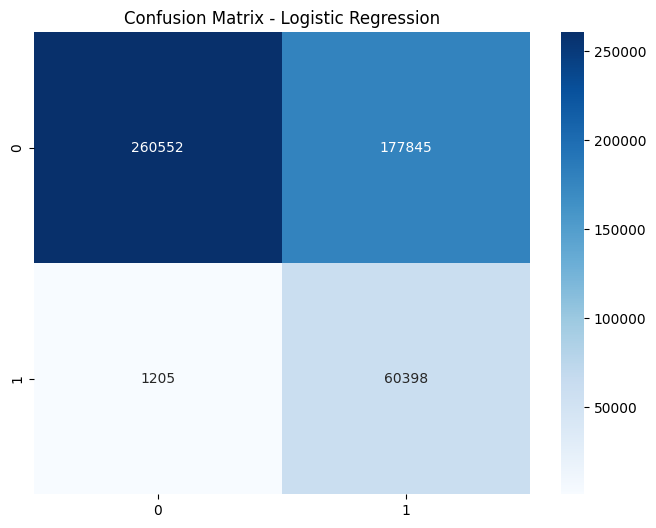

In [ ]:
print("\n" + "="*60)
print("7. Создание полного пайплайна для продакшена")
print("="*60)

# Создаем список доступных методов с их ROC-AUC
available_methods = []

# Проверяем базовую модель
if 'rf_base' in locals() or 'rf_base' in globals():
    available_methods.append(('baseline', rf_metrics['test_roc_auc']))

# Проверяем RandomizedSearchCV
if 'random_search' in locals() or 'random_search' in globals():
    available_methods.append(('randomized_search', rs_metrics['test_roc_auc']))

# Проверяем GridSearchCV
if 'grid_search_fast' in locals() or 'grid_search_fast' in globals():
    available_methods.append(('grid_search_fast', gs_metrics['test_roc_auc']))

# Проверяем HalvingGridSearchCV
if 'halving_search' in locals() or 'halving_search' in globals():
    available_methods.append(('halving_grid_search', hg_metrics['test_roc_auc']))

# Проверяем Optuna
if 'study' in locals() or 'study' in globals():
    available_methods.append(('optuna', opt_metrics['test_roc_auc']))

print("Доступные методы:")
for method_name, roc_auc in available_methods:
    print(f"  • {method_name}: ROC-AUC = {roc_auc:.4f}")

# Выбираем лучший метод
if available_methods:
    best_method_name, best_roc_auc = max(available_methods, key=lambda x: x[1])
    print(f"\n🎯 Лучший метод: {best_method_name} (Test ROC-AUC: {best_roc_auc:.4f})")
    
    # Определяем best_params в зависимости от метода
    try:
        if best_method_name == 'baseline':
            best_params = rf_base.get_params()
        elif best_method_name == 'randomized_search':
            best_params = random_search.best_params_
        elif best_method_name == 'grid_search_fast':
            best_params = grid_search_fast.best_params_
        elif best_method_name == 'halving_grid_search':
            best_params = halving_search.best_params_
        elif best_method_name == 'optuna':
            best_params = study.best_params
        
        print(f"Лучшие параметры: {best_params}")
        
        # Создаем полный пайплайн
        full_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('scaler', StandardScaler()),
            ('classifier', RandomForestClassifier(**best_params, random_state=42, n_jobs=1))
        ])
        
        # Обучаем на всех данных
        print("\nОбучаем полный пайплайн на всех данных...")
        start_time = time.time()
        full_pipeline.fit(X_train, y_train)
        train_time = (time.time() - start_time) / 60
        print(f"✓ Пайплайн обучен за {train_time:.1f} минут")
        
        # Тестируем
        y_pred_full = full_pipeline.predict(X_test)
        y_pred_proba_full = full_pipeline.predict_proba(X_test)[:, 1]
        
        full_metrics = {
            'test_roc_auc': roc_auc_score(y_test, y_pred_proba_full),
            'test_precision': precision_score(y_test, y_pred_full),
            'test_recall': recall_score(y_test, y_pred_full),
            'test_f1': f1_score(y_test, y_pred_full)
        }
        
        print(f"\n📊 Результаты полного пайплайна:")
        print(f"  Test ROC-AUC: {full_metrics['test_roc_auc']:.4f}")
        print(f"  Test F1: {full_metrics['test_f1']:.4f}")
        print(f"  Test Precision: {full_metrics['test_precision']:.4f}")
        print(f"  Test Recall: {full_metrics['test_recall']:.4f}")
        
        # Сохраняем полный пайплайн
        save_model_with_metadata(
            model=full_pipeline,
            filename='saved_models/full_production_pipeline.pkl',
            model_name=f'Full Production Pipeline ({best_method_name})',
            metrics=full_metrics,
            params=best_params
        )
        
        print("✅ Полный пайплайн создан и сохранен!")
        
    except NameError as e:
        print(f"❌ Ошибка: {e}")
        print("Пропускаем создание полного пайплайна.")
else:
    print("❌ Нет доступных обученных методов.")

# Загрузка метрик

In [ ]:
import joblib
import pandas as pd
import os

print("="*60)
print("ЗАГРУЗКА МЕТРИК ИЗ СОХРАНЕННЫХ МОДЕЛЕЙ")
print("="*60)

# Словарь для хранения метрик
all_metrics = {}

# 1. Загружаем базовую модель и берем метрики
if os.path.exists('saved_models/baseline_rf_model.pkl'):
    baseline_data = joblib.load('saved_models/baseline_rf_model.pkl')
    all_metrics['baseline'] = baseline_data['metadata']['metrics']
    print("✓ Метрики baseline загружены")

# 2. RandomizedSearchCV
if os.path.exists('saved_models/randomized_search_best_model.pkl'):
    randomized_data = joblib.load('saved_models/randomized_search_best_model.pkl')
    all_metrics['randomized'] = randomized_data['metadata']['metrics']
    print("✓ Метрики RandomizedSearchCV загружены")

# 3. GridSearchCV
if os.path.exists('saved_models/final_rf_model_fast_search.pkl'):
    grid_data = joblib.load('saved_models/final_rf_model_fast_search.pkl')
    all_metrics['grid'] = grid_data['metadata']['metrics']
    print("✓ Метрики GridSearchCV загружены")

# 4. HalvingGridSearchCV
if os.path.exists('saved_models/halving_grid_search_best_model_5fold.pkl'):
    halving_data = joblib.load('saved_models/halving_grid_search_best_model_5fold.pkl')
    all_metrics['halving'] = halving_data['metadata']['metrics']
    print("✓ Метрики HalvingGridSearchCV загружены")

# 5. Optuna
if os.path.exists('saved_models/optuna_best_model_3fold_1m.pkl'):
    optuna_data = joblib.load('saved_models/optuna_best_model_3fold_1m.pkl')
    all_metrics['optuna'] = optuna_data['metadata']['metrics']
    print("✓ Метрики Optuna загружены")

# 6. Полный пайплайн (если есть)
if os.path.exists('saved_models/full_production_pipeline.pkl'):
    pipeline_data = joblib.load('saved_models/full_production_pipeline.pkl')
    all_metrics['pipeline'] = pipeline_data['metadata']['metrics']
    print("✓ Метрики полного пайплайна загружены")

# Создаем таблицу сравнения
print("\n" + "="*60)
print("СОЗДАНИЕ ТАБЛИЦЫ СРАВНЕНИЯ")
print("="*60)

comparison_data = []

# Базовые метрики
if 'baseline' in all_metrics:
    m = all_metrics['baseline']
    comparison_data.append({
        'Method': 'Baseline RF',
        'Test ROC-AUC': m.get('test_roc_auc', m.get('Test ROC-AUC')),
        'Test Precision': m.get('test_precision', m.get('Test Precision')),
        'Test Recall': m.get('test_recall', m.get('Test Recall')),
        'Test F1': m.get('test_f1', m.get('Test F1')),
        'CV ROC-AUC': m.get('cv_mean_roc_auc', m.get('CV ROC-AUC', 'N/A'))
    })

# RandomizedSearchCV
if 'randomized' in all_metrics:
    m = all_metrics['randomized']
    comparison_data.append({
        'Method': 'RandomizedSearchCV',
        'Test ROC-AUC': m.get('test_roc_auc', m.get('Test ROC-AUC')),
        'Test Precision': m.get('test_precision', m.get('Test Precision')),
        'Test Recall': m.get('test_recall', m.get('Test Recall')),
        'Test F1': m.get('test_f1', m.get('Test F1')),
        'CV ROC-AUC': m.get('cv_best_roc_auc', m.get('CV ROC-AUC', 'N/A'))
    })

# GridSearchCV
if 'grid' in all_metrics:
    m = all_metrics['grid']
    comparison_data.append({
        'Method': 'GridSearchCV',
        'Test ROC-AUC': m.get('test_roc_auc', m.get('Test ROC-AUC')),
        'Test Precision': m.get('test_precision', m.get('Test Precision')),
        'Test Recall': m.get('test_recall', m.get('Test Recall')),
        'Test F1': m.get('test_f1', m.get('Test F1')),
        'CV ROC-AUC': m.get('cv_best_roc_auc', m.get('CV ROC-AUC', 'N/A'))
    })

# HalvingGridSearchCV
if 'halving' in all_metrics:
    m = all_metrics['halving']
    comparison_data.append({
        'Method': 'HalvingGridSearchCV',
        'Test ROC-AUC': m.get('test_roc_auc', m.get('Test ROC-AUC')),
        'Test Precision': m.get('test_precision', m.get('Test Precision')),
        'Test Recall': m.get('test_recall', m.get('Test Recall')),
        'Test F1': m.get('test_f1', m.get('Test F1')),
        'CV ROC-AUC': m.get('cv_best_roc_auc', m.get('CV ROC-AUC', 'N/A'))
    })

# Optuna
if 'optuna' in all_metrics:
    m = all_metrics['optuna']
    comparison_data.append({
        'Method': 'Optuna',
        'Test ROC-AUC': m.get('test_roc_auc', m.get('Test ROC-AUC')),
        'Test Precision': m.get('test_precision', m.get('Test Precision')),
        'Test Recall': m.get('test_recall', m.get('Test Recall')),
        'Test F1': m.get('test_f1', m.get('Test F1')),
        'CV ROC-AUC': m.get('cv_best_roc_auc', m.get('CV ROC-AUC', 'N/A'))
    })

# Пайплайн
if 'pipeline' in all_metrics:
    m = all_metrics['pipeline']
    comparison_data.append({
        'Method': 'Full Pipeline',
        'Test ROC-AUC': m.get('test_roc_auc', m.get('Test ROC-AUC')),
        'Test Precision': m.get('test_precision', m.get('Test Precision')),
        'Test Recall': m.get('test_recall', m.get('Test Recall')),
        'Test F1': m.get('test_f1', m.get('Test F1')),
        'CV ROC-AUC': 'N/A'
    })

# Создаем DataFrame
if comparison_data:
    comparison_df = pd.DataFrame(comparison_data)
    comparison_df = comparison_df.sort_values('Test ROC-AUC', ascending=False)
    
    print("\n📊 СРАВНЕНИЕ МЕТОДОВ:")
    print("-" * 100)
    print(comparison_df.to_string(index=False, float_format=lambda x: f'{x:.4f}' if isinstance(x, float) else str(x)))
    print("-" * 100)
    
    # Сохраняем
    comparison_df.to_csv('results/all_methods_comparison.csv', index=False)
    print("✓ Таблица сравнения сохранена в results/all_methods_comparison.csv")
else:
    print("❌ Нет данных для сравнения. Модели не были загружены.")

=== Decision Tree (Baseline) ===
ROC-AUC: 0.8392

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.69      0.81    438397
           1       0.29      0.91      0.44     61603

    accuracy                           0.71    500000
   macro avg       0.63      0.80      0.62    500000
weighted avg       0.90      0.71      0.76    500000

